# Create RoBERTa Model with Classification Layer

In [1]:
!pip install tensorflow-datasets --quiet
!pip install tensorflow-text --quiet
!pip install pydot --quiet
!pip install nltk --quiet
!pip install transformers --quiet
!pip install pyarrow -quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.4 MB/s eta 0:00:00

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
import random
import re

nltk.download('gutenberg')
from nltk.corpus import gutenberg

nltk.download('punkt')
from nltk.tokenize import sent_tokenize

from google.colab import drive

import pyarrow as pya
import pyarrow.parquet as pq

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# Mount drive to retrieve data frame
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.14.0


In [ ]:
# ##############################################################################
# ########### REFERENCE EXAMPLE
# ##############################################################################
from transformers import RobertaTokenizer, TFRobertaModel

checkpoint = 'roberta-base'
roberta_tokenizer = RobertaTokenizer.from_pretrained(checkpoint)
model = TFRobertaModel.from_pretrained(checkpoint)

text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='tf')
output = model(encoded_input)

text = "Your input text here."
tokens = tokenizer.encode(text, add_special_tokens=True)

input_ids = tf.constant([tokens])

outputs = model(input_ids)

In [ ]:
# ##############################################################################
# ########## REFERENCE EXAMPLE
# ##############################################################################
from transformers import TFRobertaForSequenceClassification, TFRobertaTokenizer

# Load pre-trained RoBERTa model for sequence classification
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)

# Define optimizer and learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training loop
model.fit(train_dataset, epochs=num_epochs)

In [4]:
from transformers import TFRobertaModel , TFRobertaForSequenceClassification, RobertaTokenizer

checkpoint = 'roberta-base'
roberta_tokenizer = RobertaTokenizer.from_pretrained(checkpoint)

######### TFRobertaForSequenceClassification
#model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=7)
#for layer in model.layers[:-1]:
#  layer.trainable = False
############

######## TFRoberta
#model = TFRobertaModel.from_pretrained(checkpoint)
#model.trainable = False
#classification_layer = tf.keras.layers.Dense(7, activation='softmax')
#model = tf.keras.Sequential([model,classification_layer])
############

# Define optimizer and learning rate scheduler
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model
#model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [7]:
MAX_SEQUENCE_LENGTH = 128

In [ ]:
def create_roberta_model(num_classes=2,
                         hidden_size=50,
                         dropout=0.1,
                         learning_rate=0.001):

  input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
  #token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids')
  attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')

  inputs = {'input_ids': input_ids,
            #'token_type_ids': token_type_ids,
            'attention_mask': attention_mask}

  model = TFRobertaModel.from_pretrained(checkpoint)
  model.trainable = False

  out = model(inputs)
  pooler_token = out[1]

  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)
  hidden = tf.keras.layers.Dropout(dropout, name='dropout_layer')(hidden)

  classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

  #model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
  model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics='accuracy')

  return model

In [ ]:
def create_roberta_sequential_model(num_classes=2,dropout=0.1,learning_rate=0.001):
  model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_classes)
  for layer in model.layers[:-1]:
    layer.trainable = False

  return model

In [ ]:
def create_roberta_cnn_bin(num_train_layers=0,
                           hidden_size=50,
                           dropout=0.1,
                           learning_rate=0.001):
  model = TFRobertaModel.from_pretrained(checkpoint)

  if num_train_layers == 0:
    # Freeze all layers of pre-trained BERT model
    model.trainable = False

  elif num_train_layers == 12:
    # Train all layers of the BERT model
    model.trainable = True

  else:
    # Restrict training to the num_train_layers outer transformer layers
    retrain_layers = []

    for retrain_layer_number in range(num_train_layers):
      layer_code = '_' + str(11 - retrain_layer_number)
      retrain_layers.append(layer_code)

      print('retrain layers: ', retrain_layers)

      for w in bert_model.weights:
        if not any([x in w.name for x in retrain_layers]):
          #print('freezing: ', w)
          w._trainable = False

  input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
  #token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids')
  attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')

  inputs = {'input_ids': input_ids,
            #'token_type_ids': token_type_ids,
            'attention_mask': attention_mask}

  #roberta_out = model(inputs).last_hidden_state

  roberta_out = model(inputs)
  pooler_token = out[1]

  cnn_layers = [
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    #tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
    tf.keras.layers.Reshape((-1, 256)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.2)  # Dropout for regularization
  ]

  cnn_out = pooler_token
  for layer in cnn_layers:
    cnn_out = layer(cnn_out)

  # Global max pooling layer to reduce dimensionality
  #pooled_out = tf.keras.layers.GlobalMaxPooling1D()(cnn_out)

  # Dense layer for classification
  #output = tf.keras.layers.Dense(num_classes, activation='softmax', name = 'output layer')(pooled_out)

  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cnn_out)
  hidden = tf.keras.layers.Dropout(dropout, name='dropout_layer')(hidden)

  classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

  #model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
  roberta_cnn_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

  roberta_cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics='accuracy')

  return roberta_cnn_model

In [ ]:
def create_roberta_cnn2(num_train_layers=0,
                       num_classes=2,
                       hidden_size=50,
                       dropout=0.1,
                       learning_rate=0.001):

  model = TFRobertaModel.from_pretrained(checkpoint)

  if num_train_layers == 0:
    # Freeze all layers of pre-trained BERT model
    model.trainable = False

  elif num_train_layers == 12:
    # Train all layers of the BERT model
    model.trainable = True

  else:
    # Restrict training to the num_train_layers outer transformer layers
    retrain_layers = []

    for retrain_layer_number in range(num_train_layers):
      layer_code = '_' + str(11 - retrain_layer_number)
      retrain_layers.append(layer_code)

    print('retrain layers: ', retrain_layers)

    for w in model.weights:
      if not any([x in w.name for x in retrain_layers]):
        #print('freezing: ', w)
        w._trainable = False

  input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
  #token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids')
  attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')

  inputs = {'input_ids': input_ids,
            #'token_type_ids': token_type_ids,
            'attention_mask': attention_mask}

  out = model(inputs)
  pooler_token = out[1]

  cnn_layers = [
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=96, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),  # Dropout for regularization
    tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
    #tf.keras.layers.Reshape((-1, 256)),
    tf.keras.layers.GlobalMaxPooling1D(),
  ]

  cnn_out = pooler_token
  #cnn_out = pooler_token
  for layer in cnn_layers:
    cnn_out = layer(cnn_out)

  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cnn_out)
  hidden = tf.keras.layers.Dropout(dropout, name='dropout_layer')(hidden)

  classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

  #model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
  model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics='accuracy')

  return model

In [5]:
# Create RoBERTa with CNN
# multi-modal or multi-channel approach, where the RoBERTa model processes the input text,
# and the CNN layer processes the sequential embeddings produced by RoBERTa.
# This can be beneficial when you want to capture local patterns and relationships
# in addition to the global contextual information provided by the transformer model.
def create_roberta_cnn(num_train_layers=0,
                       num_classes=2,
                       hidden_size=50,
                       dropout=0.1,
                       learning_rate=0.001):
  roberta_model  = TFRobertaModel.from_pretrained(checkpoint)

  if num_train_layers == 0:
    # Freeze all layers of pre-trained BERT model
    roberta_model.trainable = False

  elif num_train_layers == 12:
    # Train all layers of the BERT model
    roberta_model.trainable = True

  else:
    # Restrict training to the num_train_layers outer transformer layers
    # Restrict training to the num_train_layers outer transformer layers
        #retrain_layers = [str(11 - i) for i in range(num_train_layers)]
        #print('Retraining layers: ', retrain_layers)

        #for layer in roberta_model.layers:
        #    print(layer.name)
        #    layer.trainable = any([x in layer.name for x in retrain_layers])
    layers_to_train = roberta_model.layers[-num_train_layers:]
    for layer in layers_to_train:
      layer.trainable = True

  input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
  attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')

  inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

  roberta_out = roberta_model(inputs)[0]  # Extract the last hidden state

  cnn_layers = [
        tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu',name='CNN1'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', name='CNN2'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu', name='CNN3'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', name='CNN4'),
        tf.keras.layers.MaxPooling1D()
  ]

  cnn_out = roberta_out
  for layer in cnn_layers:
      cnn_out = layer(cnn_out)

  # Global max pooling layer to reduce dimensionality
  cnn_out = tf.keras.layers.GlobalMaxPooling1D()(cnn_out)

  cnn_out = tf.keras.layers.Flatten()(cnn_out)

  # Dense layer for classification
  #output = tf.keras.layers.Dense(num_classes, activation='softmax', name = 'output layer')(pooled_out)

  # Fully connected layers for classification
  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(cnn_out)
  hidden = tf.keras.layers.Dropout(dropout, name='dropout_layer')(hidden)
  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer2')(hidden)
  classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(hidden)

  roberta_cnn_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

  # Exclude non-trainable variables from the list of trainable variables
  trainable_vars = [var for var in roberta_cnn_model.trainable_variables if 'pooler' not in var.name]

  roberta_cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                              metrics=['accuracy'])

  return roberta_cnn_model

In [8]:
#model = create_roberta_model(num_classes=7)
model = create_roberta_cnn(num_classes=7, num_train_layers=0, hidden_size=128, learning_rate=0.001)
#model = create_roberta_cnn_bin()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model_4 (TFRobe  TFBaseModelOutputWithPooli   1246456   ['attention_mask[0][0]',      
 rtaModel)                   ngAndCrossAttentions(last_   32         'input_ids[0][0]']           
                             hidden_state=(None, 128, 7                                     

In [9]:
def create_encoding(data, label):
  data_encodings = roberta_tokenizer(data,
                        max_length=MAX_SEQUENCE_LENGTH,
                        truncation=True,
                        padding='max_length',
                        return_tensors='tf')

  label_encodings = np.array(label)
  # label_encodings = torch.tensor(label)

  return (data_encodings, label_encodings)



In [10]:
# Define a callback to save weights after each batch
from tensorflow.keras.callbacks import Callback

class SaveWeightsCallback(Callback):
    def __init__(self, model_name):
        super(SaveWeightsCallback, self).__init__()
        self.model_name = model_name

    #def on_batch_end(self, batch, logs=None):
    #    model_filename = f"/content/drive/My Drive/w266/training/{self.model_name}_weights.h5"
    #    self.model.save_weights(model_filename)

    def on_epoch_end(self, epoch, logs=None):
        model_filename = f"/content/drive/My Drive/w266/training/{self.model_name}_weights_epoch{epoch}.h5"
        self.model.save_weights(model_filename)

# Create a custom callback to stop within a single epoch if accuracy doesn't change much between iterations
class CustomStopCallbackWithinEpoch(Callback):
    def __init__(self, delta=0.01, patience=2, threshold=0.50):
        super(CustomStopCallbackWithinEpoch, self).__init__()
        self.delta = delta
        self.patience = patience
        self.threshold = threshold
        self.wait = 0
        self.best_accuracy = -1

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')

        if accuracy is not None and accuracy > self.threshold:
            if np.abs(accuracy - self.best_accuracy) > self.delta:
                self.wait = 0
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.model.stop_training = True
                    print(f"\nStopping training within epoch {epoch + 1} because accuracy hasn't improved for the last {self.patience} iterations.")
            if accuracy > self.best_accuracy:
              self.best_accuracy = accuracy

In [11]:
save_weights_callback = SaveWeightsCallback(model_name='roberta_multi_bal')
custom_stop_callback = CustomStopCallbackWithinEpoch(delta=0.01, patience=2, threshold=0.7)

In [12]:
# Create Train and Validation encodings
BATCH_SIZE = 24

# Load Test Data and prepare encodings
file_path = "/content/drive/My Drive/w266/data/"
train_file = file_path + "gut_corpus_train_data_multi_bal.parquet"
valid_file = file_path + "gut_corpus_valid_data_multi_bal.parquet"
test_file = file_path + "gut_corpus_test_data_multi_bal.parquet"
#train_file = file_path + "gut_corpus_train_data_binary6_small.parquet"
#valid_file = file_path + "gut_corpus_valid_data_binary6_small.parquet"
#test_file = file_path + "gut_corpus_test_data_binary6_small.parquet"

data = pya.parquet.read_table(train_file)
df_train = data.to_pandas()
data = pya.parquet.read_table(valid_file)
df_valid = data.to_pandas()
data = pya.parquet.read_table(test_file)
df_test = data.to_pandas()

train_data = []
train_label = []
valid_data = []
valid_label = []
test_data  = []
test_label = []

for indx, row in df_train.iterrows():
  train_data.append(row[0])
  train_label.append(row[1])
for indx, row in df_valid.iterrows():
  valid_data.append(row[0])
  valid_label.append(row[1])
for indx, row in df_test.iterrows():
  test_data.append(row[0])
  test_label.append(row[1])

# Create a dataset
train_encodings, train_enc_label = create_encoding(train_data, train_label)
valid_encodings, valid_enc_label = create_encoding(valid_data, valid_label)
test_encodings, test_enc_label = create_encoding(test_data, test_label)

dataset_training = tf.data.Dataset.from_tensor_slices(
    (
        {
            'input_ids': train_encodings['input_ids'],
            #'token_type_ids': train_encodings['token_type_ids'],
            'attention_mask': train_encodings['attention_mask']
        },
        train_enc_label
    )
)

#dataset_training = dataset_training.batch(BATCH_SIZE)  # Batch size

# Shuffle and batch the dataset (you can adjust batch size and other parameters as needed)
dataset_training = dataset_training.shuffle(buffer_size=len(train_enc_label)).batch(BATCH_SIZE)


dataset_validation = tf.data.Dataset.from_tensor_slices(
    (
        {
            'input_ids': valid_encodings['input_ids'],
            #'token_type_ids': valid_encodings['token_type_ids'],
            'attention_mask': valid_encodings['attention_mask']
        },
        valid_enc_label
    )
)

dataset_validation = dataset_validation.batch(BATCH_SIZE)

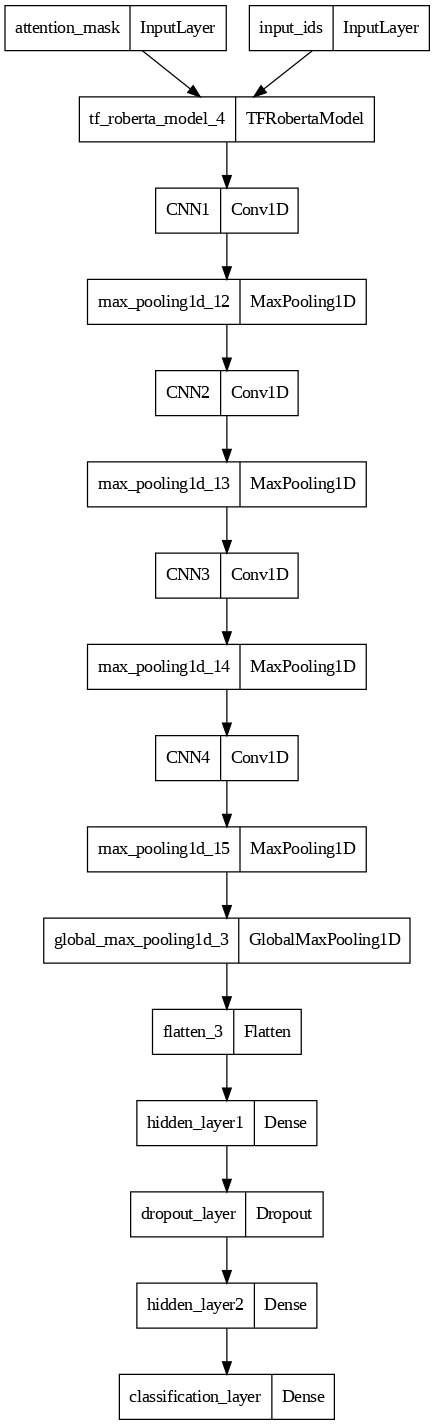

In [ ]:
keras.utils.plot_model(model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [ ]:
# Train the model with the SaveWeightsCallback
#model_history = model.fit(
#    dataset_training,
#    validation_data=dataset_validation,
#    epochs=1,
#    callbacks=[save_weights_callback, custom_stop_callback])

model_history = model.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=2,
    callbacks=save_weights_callback)

Epoch 1/2
89/89 [==============================] - 1342s 15s/step - loss: 1.6189 - accuracy: 0.3141 - val_loss: 1.2582 - val_accuracy: 0.4784
Epoch 2/2
89/89 [==============================] - 1301s 15s/step - loss: 1.1617 - accuracy: 0.5057 - val_loss: 1.0664 - val_accuracy: 0.5548


In [13]:
# AS NEEDED: Reload weights and run for longer
model.load_weights("/content/drive/My Drive/w266/training/roberta_multi_bal_weights_epoch1.h5")

In [ ]:
# AS NEEDED: Reload weights and run for longer
model_history = model.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=2,
    callbacks=save_weights_callback)

Epoch 1/2
67/67 [==============================] - 1196s 18s/step - loss: 1.1540 - accuracy: 0.5260 - val_loss: 1.1099 - val_accuracy: 0.5714
Epoch 2/2
67/67 [==============================] - 1216s 18s/step - loss: 1.0163 - accuracy: 0.5705 - val_loss: 1.1516 - val_accuracy: 0.5681


In [14]:
# OPTIONAL: create a smaller Test dataset
test_data_small = []
test_label_small = []
size_factor = 0.1

size = int(size_factor*len(df_test))

for indx, row in df_test.iterrows():
  if indx < size:
    test_data_small.append(row[0])
    test_label_small.append(row[1])
  else:
    break

test_encodings_small, test_enc_label_small = create_encoding(test_data_small, test_label_small)

In [15]:
#predictions = model.predict([test_encodings.input_ids, test_encodings.attention_mask])
predictions = model.predict([test_encodings_small.input_ids, test_encodings_small.attention_mask])

22/22 [==============================] - 413s 19s/step


In [16]:
np.savetxt('/content/drive/My Drive/w266/predictions_roberta_cnn_nn_multi_bal.csv', predictions)

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

prediction_max = []
for i in range(len(predictions)):
  prediction_max.append(np.argmax(predictions[i]))

# Generate confusion matrix
#conf_matrix = confusion_matrix(test_label, prediction_max)
conf_matrix = confusion_matrix(test_label_small, prediction_max)

# Calculate accuracy using TensorFlow
accuracy = tf.keras.metrics.Accuracy()
#accuracy.update_state(test_label, prediction_max)
accuracy.update_state(test_label_small, prediction_max)
accuracy_result = accuracy.result().numpy()

# Calculate precision, recall, and F1 score using TensorFlow
precision = tf.keras.metrics.Precision()
#precision.update_state(test_label, prediction_max)
precision.update_state(test_label_small, prediction_max)
precision_result = precision.result().numpy()

recall = tf.keras.metrics.Recall()
#recall.update_state(test_label, prediction_max)
recall.update_state(test_label_small, prediction_max)
recall_result = recall.result().numpy()

f1 = 2 * (precision_result * recall_result) / (precision_result + recall_result)

# Print confusion matrix and metrics
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy_result)
print("\nPrecision:", precision_result)
print("Recall:", recall_result)
print("F1 Score:", f1)

# Classification report using scikit-learn
#class_report = classification_report(test_label, prediction_max)
class_report = classification_report(test_label_small, prediction_max)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[91  0  0  0  1  4  1]
 [19 41  0  0  1  0  0]
 [19  1  6 41 65 47  2]
 [11  1  5 23 32 46  0]
 [ 2  0  1  5 82  5  3]
 [39  1  1  8  4 36  0]
 [ 4  0  0  0  1  0 39]]

Accuracy: 0.4622093

Precision: 0.98807156
Recall: 0.84094757
F1 Score: 0.9085923908636971

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.94      0.65        97
           1       0.93      0.67      0.78        61
           2       0.46      0.03      0.06       181
           3       0.30      0.19      0.24       118
           4       0.44      0.84      0.58        98
           5       0.26      0.40      0.32        89
           6       0.87      0.89      0.88        44

    accuracy                           0.46       688
   macro avg       0.54      0.57      0.50       688
weighted avg       0.48      0.46      0.40       688



In [ ]:
test_label[0:20]

[1, 4, 4, 0, 1, 5, 3, 3, 6, 5, 5, 0, 2, 2, 0, 2, 2, 2, 3, 2]